# Exploring Bay Wheels' Bike Share trip data
## by Mayukh Chakravartti

This dataset contains the bike trip details for Bay Wheel's bike sharing program

## Investigation Overview

The objective of this investigation is to review the data available for the Bay Wheel bike sharing program to gather crucial insights into the working of this service, user behavior and gather analytical information

## Dataset Overview

This dataset contains the bike trip details for Bay Wheel's bike sharing program. The data contains the details of the bike trips starting from June-2017 till September-2019. There is information regarding how long the rides were, the origin and end points of the rides, gender and age information of riders.

## Import and Constants

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os

%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [2]:
# Constants
data_folder_local = '/Users/mayukh/Documents/Google Drive-Data Science/Colab Notebooks/Data Visualization/Project/Data/'
base_color = sb.color_palette()[0]

## Load and Cleanup Dataset

In [3]:
# Load the data
all_files = glob.glob(os.path.join(data_folder_local, '*.csv'))
df_bikedata = pd.concat((pd.read_csv(f, low_memory=False) for f in all_files), sort=False, ignore_index=True)
df_bikedata.reset_index(drop=True, inplace=True)

In [4]:
# Cleanup the data
# Change column type to DatTime
df_bikedata.start_time = pd.to_datetime(df_bikedata.start_time)
df_bikedata.end_time = pd.to_datetime(df_bikedata.end_time)
# Data Cleanup 2 Change Birth Year to an integer instead of a int64
df_bikedata.member_birth_year = df_bikedata.member_birth_year.fillna(0).astype(int)
# Data Cleanup 3 Cleanup the column member_gender
di = {'M': 'Male', 
      'F': 'Female',
      'O': 'Other',
      'Male': 'Male',
      'Female': 'Female',
      'Other': 'Other'}
df_bikedata.member_gender = df_bikedata.member_gender.map(di)
# Data Cleanup 4 Change columns user_type, member_gender, rental_access_method to categorical
df_bikedata.user_type = df_bikedata.user_type.astype('category')
df_bikedata.member_gender = df_bikedata.member_gender.astype('category')
df_bikedata.rental_access_method = df_bikedata.rental_access_method.astype('category')
# Lets add a minute column for Duration
df_bikedata['duration_min'] = round(df_bikedata.duration_sec/60).astype(int)
# Some additional columns to be used for Data Visualization
df_bikedata['Start_Year_Month']=df_bikedata.start_time.dt.strftime('%Y-%m')
df_bikedata['member_age'] =  df_bikedata.start_time.dt.year - df_bikedata.member_birth_year
df_bikedata['Start_Time_Hour'] = df_bikedata.start_time.dt.hour
df_bikedata['Start_Day_Of_Week'] = df_bikedata.start_time.dt.weekday_name
day_type = {'Monday':'Weekday', 'Tuesday':'Weekday', 'Wednesday':'Weekday', 'Thursday':'Weekday', 'Friday':'Weekday', 'Saturday':'Weekend', 'Sunday':'Weekend'}
df_bikedata['Start_Day_Type'] = df_bikedata.Start_Day_Of_Week.apply(lambda x: day_type[x])

## The growth story so far

> We explore how the number of Bike rides have trended since the start of the ride

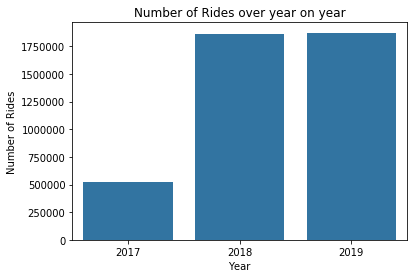

In [5]:
sb.countplot(data=df_bikedata, x=df_bikedata.start_time.dt.year, color=base_color);
plt.xlabel('Year');
plt.ylabel('Number of Rides');
plt.title('Number of Rides over year on year');

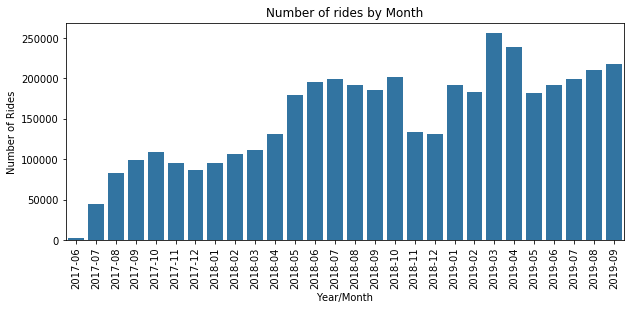

In [6]:
order = np.array(df_bikedata.Start_Year_Month.sort_values().unique())
plt.figure(figsize=(10,4));
sb.countplot(data=df_bikedata, x='Start_Year_Month', color=base_color, order=order);
plt.xlabel('Year/Month');
plt.ylabel('Number of Rides');
plt.xticks(rotation=90);
plt.title('Number of rides by Month');

- This service has seen rising popularity with time. The number of rides using this service has increased every year. Even on a monthly breakup of ridership numbers, it is seen that there is an upward trend. This service is growing.

- It does show a dip during the Nov-Dec months which we will addres later in the following section.

## A deeper understanding of what people are using this service for

> In order to understand this, we delve into the times at which we see this service being used the most.

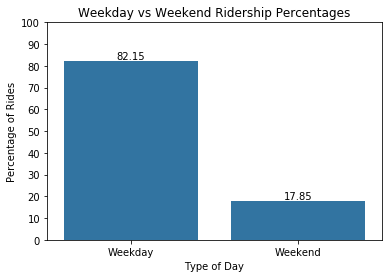

In [7]:
total_rides = df_bikedata.shape[0]
max_typeofday_count = df_bikedata.Start_Day_Type.value_counts().max()
max_prop = max_typeofday_count / total_rides
ytick_values = np.arange(0, max_prop + 0.2, 0.1)
yticks_labels = ['{:0.0f}'.format(v*100) for v in ytick_values]
ax = sb.countplot(data=df_bikedata, x='Start_Day_Type', color=base_color);
plt.xlabel('Type of Day');
plt.ylabel('Percentage of Rides');
plt.yticks(ytick_values*total_rides, yticks_labels);
total = df_bikedata.shape[0]
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/2,
          height + 40000,
          '{:1.2f}'.format(100*height/total),
          ha="center")
plt.title('Weekday vs Weekend Ridership Percentages');

- Almost 82% of the rides happen on weekdays against around 18% on weekdays

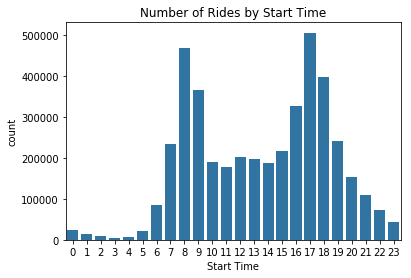

In [8]:
sb.countplot(data=df_bikedata, x=df_bikedata.start_time.dt.hour, color=base_color)
plt.xlabel('Start Time');
plt.title('Number of Rides by Start Time');

- It is also clear now that the most rides in the day happen in the morning around 8 and in the evening 5
- Considering the fact that most rides happen on weekdays, we can surmise that most people are using this service to commute to work/school
- This is the service's primary user base
- Earlier we had noticed a dip in the number of rides during the Nov-Dec time of the year. Considering the primary userbase of working professionals and students, it is possible that this dip is due to the holiday season at the end of the year, when a lot of people are on vacation/travelling or are working from home.

## What is the demographic of the user base
> Here we try to explore more details about the user base - gender, age

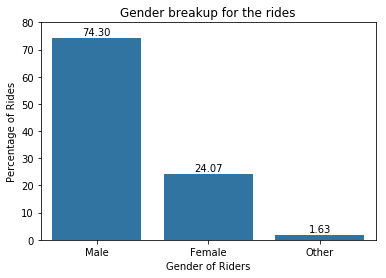

In [9]:
df_bikedata_tmp = df_bikedata.dropna(subset=['member_gender'])
total_rides = df_bikedata_tmp.shape[0]
max_gender_count = df_bikedata_tmp.member_gender.value_counts().max()
max_prop = max_gender_count / total_rides
ytick_values = np.arange(0, max_prop + 0.1, 0.1)
yticks_labels = ['{:0.0f}'.format(100*v) for v in ytick_values]
order_gender_plot = df_bikedata_tmp.member_gender.value_counts().index
ax = sb.countplot(data=df_bikedata_tmp, x='member_gender', color=base_color, order=order_gender_plot)
plt.yticks(ytick_values*total_rides, yticks_labels);
plt.xlabel('Gender of Riders')
plt.ylabel('Percentage of Rides');
total = df_bikedata_tmp.shape[0]
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x()+p.get_width()/2,
          height+40000,
          '{:1.2f}'.format(100*height/total),
          ha="center")
plt.title('Gender breakup for the rides');

- Here we notice that almost 74% of the rides are being done by Men, while only 24% are being done by women. 
- It might help the organization to delve deeper into understanding why women are not using this service as much as men. Could we do things better or differently to ensure that they are participants as well?

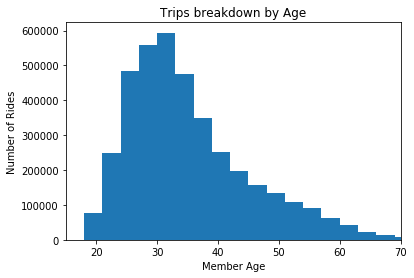

In [10]:
df_bikedata_tmp = df_bikedata[df_bikedata.member_age<100] # exlcuding the records where the age is invalid 
bins_x = np.arange(df_bikedata_tmp.member_age.min()-3, df_bikedata_tmp.member_age.max() + 1, 3)
#bins_y = np.arange(df_bikedata_tmp.duration_min.min()-3, df_bikedata_tmp.duration_min.max()+1, 3)
plt.hist(data=df_bikedata_tmp, x='member_age', bins=bins_x);
plt.xlabel('Member Age');
plt.ylabel('Number of Rides');
plt.xlim((15, 70)); # Limiting it to the bulk of the data
plt.title('Trips breakdown by Age');

- Most trips are being undertaken by people in the age group of 25 to 35.
- In order to popularize the service amongst other age groups - are there accessibility options that can be provided like powered bikes for older people or maybe more colorful bikes for even younger ones.


## What are the most popular locations
> We want to explore which stations are the most popular with riders. How has it trended over time 

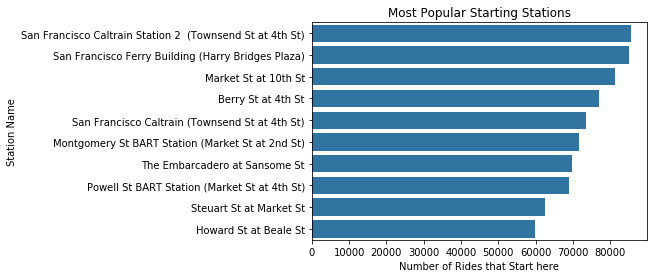

In [11]:
order = df_bikedata.start_station_name.value_counts()[:10].index
sb.countplot(data=df_bikedata, y='start_station_name', color=base_color, order=order);
plt.xlabel('Number of Rides that Start here');
plt.ylabel('Station Name');
plt.title('Most Popular Starting Stations');

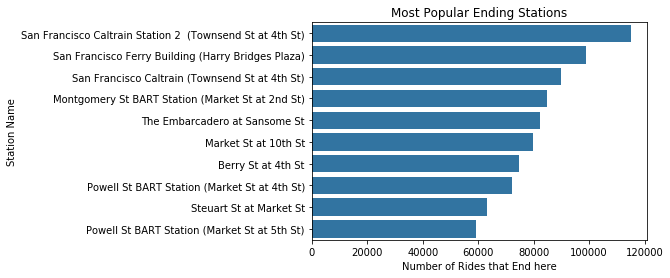

In [12]:
sb.countplot(data=df_bikedata, y='end_station_name', color=base_color, order=df_bikedata.end_station_name.value_counts()[:10].index);
plt.xlabel('Number of Rides that End here');
plt.ylabel('Station Name');
plt.title('Most Popular Ending Stations');

- Looks like the 'San Francisco Caltrain Station 2' is both the most popular starting and end points for now. 
- Lets take a look at the popularity trend for these stations

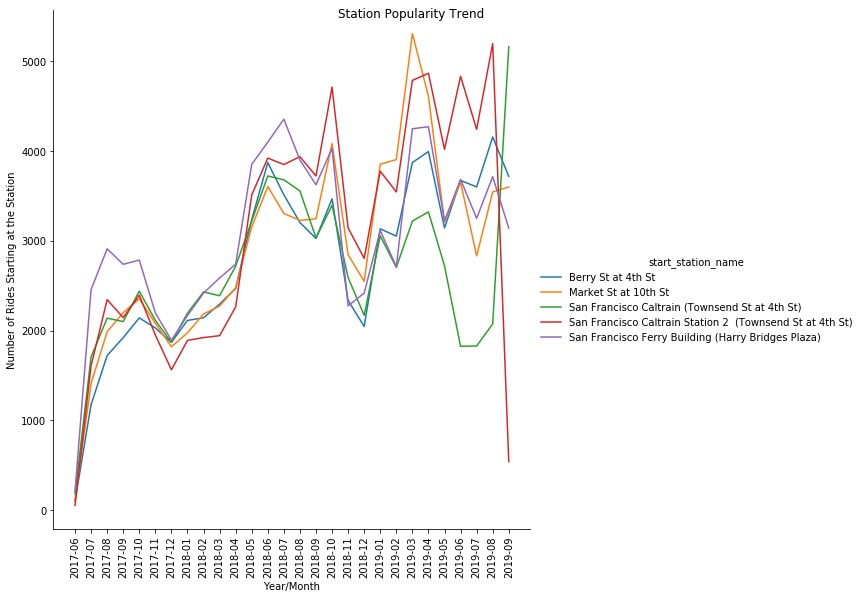

In [13]:
df_temp = df_bikedata[df_bikedata.start_station_name.isin(df_bikedata.start_station_name.value_counts()[:5].index)]
df_temp = df_temp.groupby(['start_station_name', 'Start_Year_Month'], as_index=False).agg({'duration_min': 'count'})
df_temp.rename(columns={'duration_min': 'number_of_rides'}, inplace=True)
df_temp.sort_values(['start_station_name', 'Start_Year_Month'], ascending=[True, True], inplace=True)
g = sb.FacetGrid(data=df_temp, hue='start_station_name', height=8);
g.map(plt.plot, 'Start_Year_Month', 'number_of_rides');
g.set_titles('{col_name}');
g.add_legend();
g.set_axis_labels("Year/Month", "Number of Rides Starting at the Station");
for ax in g.axes.flat:
  for label in ax.get_xticklabels():
    label.set_rotation(90)
g.fig.suptitle('Station Popularity Trend');

- San Francisco Ferry Building station started out as the most popular station for more than a year till Aug 2018 where it was overtaken by the Caltrain Station 2
- Market St at 10th Station briefly took the crown of the most popular starting station between Jan and Mar of 2019
- For the last month of September 2019, there is a drastic drop in the number of rides in San Francisco Caltrain Station 2 (Townsend St at 4th Street) and a similar drastic increase in the number of rides for San Francisco Caltrain (Townsend St at 4th St). These are not the same exact ride stations, however close. It should be checked if this is due to a planned merge or transfer of these stations or due to any temporary reasons.

## How has the growth in the number of stations impacted Ridership and Ride durations
> As this service has expanded to more stations in the city, we want to explore how this impacted the number of rides and ride durations

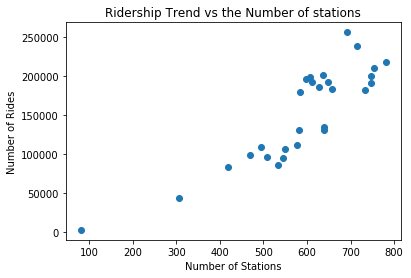

In [14]:
df_temp = df_bikedata.groupby(['Start_Year_Month'], as_index=False).agg({'start_station_name': pd.Series.nunique, 'end_station_name': pd.Series.nunique, 'duration_sec': 'count'})
df_temp.rename(columns={'start_station_name': 'number_of_start_stations', 'end_station_name': 'number_of_end_stations', 'duration_sec': 'number_of_rides' }, inplace=True)
df_temp['total_stations'] = df_temp.number_of_start_stations + df_temp.number_of_end_stations
df_temp.sort_values(['Start_Year_Month'], ascending=[True], inplace=True)
df_temp.head()
plt.scatter(data=df_temp, x='total_stations', y='number_of_rides');
plt.xlabel('Number of Stations');
plt.ylabel('Number of Rides');
plt.title('Ridership Trend vs the Number of stations');

- This graph shows that the number of rides have increased with addition of stations. The critical jump in ridership happened when the number of stations went from 500 to 600 stations where the number of rides increased from 80,000 to almost 200,000

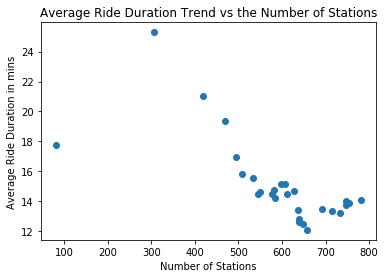

In [15]:
df_temp = df_bikedata.groupby(['Start_Year_Month'], as_index=False).agg({'start_station_name': pd.Series.nunique, 'end_station_name': pd.Series.nunique, 'duration_min': 'mean'})
df_temp.rename(columns={'start_station_name': 'number_of_start_stations', 'end_station_name': 'number_of_end_stations', 'duration_min': 'avg_duration_min' }, inplace=True)
df_temp['total_stations'] = df_temp.number_of_start_stations + df_temp.number_of_end_stations
df_temp.sort_values(['total_stations'], ascending=[True], inplace=True)
df_temp.head()
plt.scatter(data=df_temp, x='total_stations', y='avg_duration_min');
plt.xlabel('Number of Stations');
plt.ylabel('Average Ride Duration in mins');
plt.title('Average Ride Duration Trend vs the Number of Stations');

- As the number of stations increased, the number of rides increased, however due to the availability of more stations, the average ride duration has decreased
- From a cost effectiveness, we need to explore how to balance number of rides vs average trip duration more effectively.

## What is the average duration of a ride
> How long does an average ride last

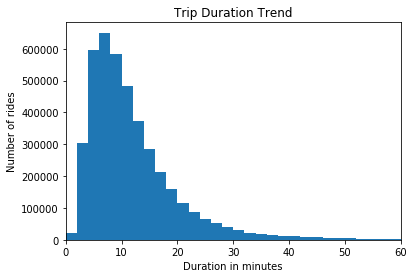

In [16]:
bins = np.arange(0, df_bikedata.duration_min.max()+2, 2)
plt.hist(data=df_bikedata, x='duration_min', bins=bins);
plt.xlim((0, 60));
plt.xlabel('Duration in minutes');
plt.ylabel('Number of rides');
plt.title('Trip Duration Trend');

- Most bike rides are between 7 and 11 minutes long

## How has the trip duration trended over time
> Here we explore how the average trip duration has trended over time

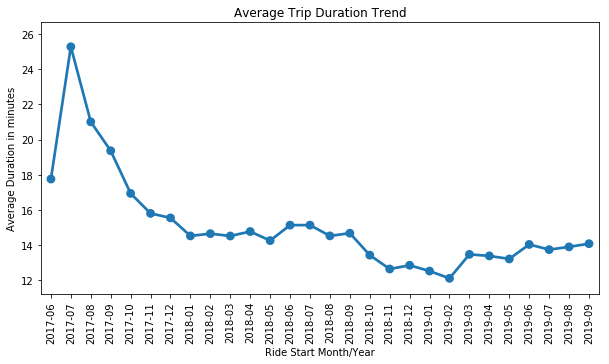

In [17]:
order = df_bikedata.Start_Year_Month.sort_values().unique()
plt.figure(figsize=(10,5));
sb.pointplot(data=df_bikedata, x='Start_Year_Month', y='duration_min', color=base_color, order=order, errwidth=0);
plt.xticks(rotation=90);
plt.ylabel('Average Duration in minutes');
plt.xlabel('Ride Start Month/Year');
plt.title('Average Trip Duration Trend');

- The average ride duration seems to have started off with a bang initially and then tapered off once the service matured and added more stations

## How has the trip duration varied based on the 10 most popular stations
> Here we take a look at the 10 most popular starting stations and analyze the average ride duration from here

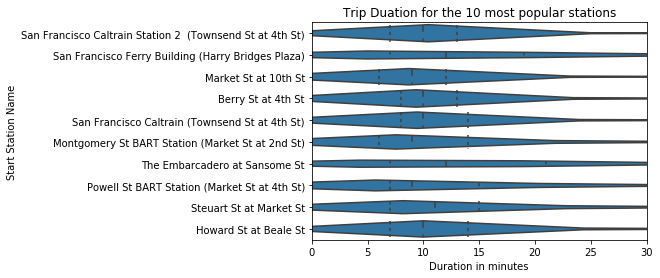

In [18]:
df_bikedata_wo_na = df_bikedata.dropna(subset=['start_station_name'])
order=df_bikedata.start_station_name.value_counts()[:10].index
sb.violinplot(data=df_bikedata_wo_na, y='start_station_name', x='duration_min', order=order, color=base_color, inner='quartile');
plt.xlim((0, 30)); # Zooming in on the bulk of the data
plt.xlabel('Duration in minutes');
plt.ylabel('Start Station Name');
plt.title('Trip Duation for the 10 most popular stations');

- Most of the average trip duration for these top 10 stations vary between 8 and 13 mins. Interestingly, for San Francisco Ferry Building station and The Embercado station, its almost an equal spread in terms of the number of rides by duration till 20 min mark

## How does the trip duration differ between Women and Men
> This provides an inisght into ride durations compare between between men and women

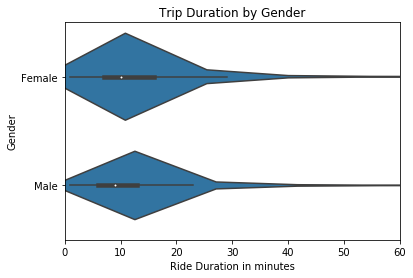

In [19]:
df_bikedata_tmp = df_bikedata[df_bikedata.member_gender.isin(['Male', 'Female'])]
sb.violinplot(data=df_bikedata_tmp, y='member_gender', x='duration_min', color=base_color, order=['Female', 'Male']);
plt.ylabel('Gender');
plt.xlabel('Ride Duration in minutes');
plt.xlim((0, 60)); # Restricting to the bulk of the data
plt.title('Trip Duration by Gender');

- The average trip duration for women are higher than that of men
- Interestingly, women are using this service disproportionately lesser than men, only 24%. This could be an area of focus for future growth

## Key Takeaways
- The service is seeing consistent growth over time year on year
- Primary user base is Male (with a 75% share) used presumably for commuting to work/school during weekdays
- Women are using this service much lesser (only 24% of the riders are women) than men. However, they are using it for longer on an average. This opportunity should be explored.
- The primary age group is 25 to 35 years of age. Again there are oppotunities to popularize this service amongst other age groups
- Addition of new stations have increased the ridership numbers especially from 500 to 600 stations, however since the last 100 stations added, there seems to be a plateauing in the ridership increases. There needs to be more analysis before the next wave of station creation.

Thank you!